In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import *; from tools.BLtools import *; from tools.e5tools import *
from tropicalOrographicRegions.mountainUtils import tilted_rect

from scipy.stats import linregress
#xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Data

In [2]:
import dask
from dask.distributed import Client, LocalCluster
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(n_workers=8,threads_per_worker=4,memory_limit='10G')
client

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45011 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:45011/status,
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:45011/status,Workers: 8
Total threads: 32,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39383,Workers: 8
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:45011/status,Total threads: 32
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:36877,Total threads: 4
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:37933/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:37203,


## Simulations

In [2]:
from tools.wrfHrTools import Simulation,change_coords_pl

In [14]:
class SimulationCustom2(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False,type2=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        if type2:
            RAINNC_DAILY = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%suffix2).RAINNC_MMDY[1200:].mean('south_north').coarsen(Time=24,boundary='trim').mean()
            self.RAINNC_DAILY = RAINNC_DAILY
            self.RAINNC_MEAN = RAINNC_DAILY.mean('Time').load()
            self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
        
        else:
            RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY.mean('south_north').coarsen(Time=24).mean()
            self.RAINNC_DAILY_FULL = RAINNC_DAILY
            RAINNC_DAILY = RAINNC_DAILY[:430]
            self.RAINNC_DAILY = RAINNC_DAILY
            self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
            #self.RAINNC_MEAN = xr.open_dataarray(self.path+'wrf.RAINNC.ALLMEAN.nc')
            self.RAINNC_MEAN = RAINNC_DAILY.mean('Time').load()
        
        
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

W10S296   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/'          ,1635,3,'1970010100-1970090900',inp=True)
W12S296   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K12mps.3km/'     ,1635,3,'1970010100-1971042600',inp=True,type2=True)   

In [15]:
W10S296.color='m'
W12S296.color='purple'

W10S296.label=r'$SST=296K, U = 10$ m$\,$s$^{-1}$'
W12S296.label=r'$SST=296K, U = 12$ m$\,$s$^{-1}$'

In [16]:
def upstream_mean(ds,reverse=False):
    if reverse:
        return ds.sel(distance_from_mtn=slice(-4000,-2500)).mean('distance_from_mtn')
    else:
        return ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')
def prime(ds,reverse=False):
    return ds - upstream_mean(ds,reverse)

In [7]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile
xx,hx=topographic_profile('cos',A=500.)

In [8]:
for Sim in W10S296 , W12S296:
    Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
    Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")
    
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')
    Sim.OMEGA_PL_MEAN = -Sim.T_PL_MEAN.pressure*100/(287. * Sim.T_PL_MEAN) * 9.81 * Sim.W_PL_MEAN
    udthetaedx = -(Sim.U_PL_MEAN*Sim.THETAE_MEAN.differentiate('distance_from_mtn')/1000 * 86400)
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*Sim.THETAE_MEAN.differentiate('pressure')/100 * 86400)
    Qthetae = udthetaedx+omegadthetaedp
    Sim.OMEGADTHETAEDP = omegadthetaedp
    
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*upstream_mean(W10S296.THETAE_MEAN).differentiate('pressure')/100 * 86400)
    Sim.OMEGADTHETAE0DP = omegadthetaedp
    
    Sim.QTHETAE = Qthetae

In [17]:
def averageB(ds,psfc,ptop=850):
    ds = ds.bfill(dim='pressure')
    p1 = 990;p2=ptop
    part1 = -ds.sel(pressure=slice(p1,p2)).integrate('pressure')
    part2 = ds.sel(pressure=p1)*(psfc-990)
    return ((part1+part2)/(psfc-ptop))
def averageL(ds,p1 = 850,p2 = 500):
    return (-ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(p1-p2))

In [18]:
test = xr.open_dataset(W12S296.path+'wrfout_d01_1970-02-10_06_00_00')
test2 = xr.open_dataset(W12S296.path+'wrfout_d01_1972-09-17_06_00_00')
test3 = xr.open_dataset(W12S296.path+'wrfout_d01_1971-04-16_06_00_00')

In [19]:
from tools.wrfHrTools import change_coords_sfc

(-1100.0, 1100.0)

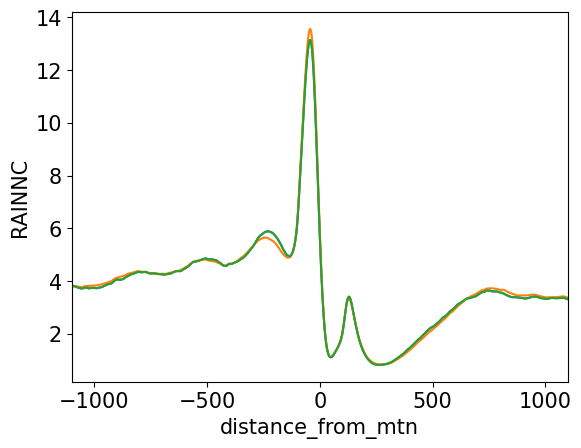

In [22]:
W12S296.RAINNC_MEAN.plot()
change_coords_sfc(((test2.RAINNC[-1]-test.RAINNC[-1])/(950)).mean('south_north')).plot()
change_coords_sfc(((test3.RAINNC[-1]-test.RAINNC[-1])/(430)).mean('south_north')).plot()
plt.xlim(-1100,1100)

In [24]:
(prime(W12S296.RAINNC_MEAN).max()/prime(W10S296.RAINNC_MEAN).max()-1)*50

<xarray.DataArray 'RAINNC_MMDY' ()>
array(12.1220658)

In [25]:
W12S296.RAINNC_MEAN = change_coords_sfc(((test2.RAINNC[-1]-test.RAINNC[-1])/(950))).mean('south_north')

In [26]:
(prime(W12S296.RAINNC_MEAN).max()/prime(W10S296.RAINNC_MEAN).max()-1)*50

<xarray.DataArray ()>
array(14.99243779)

# Simulations - T' and P'

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

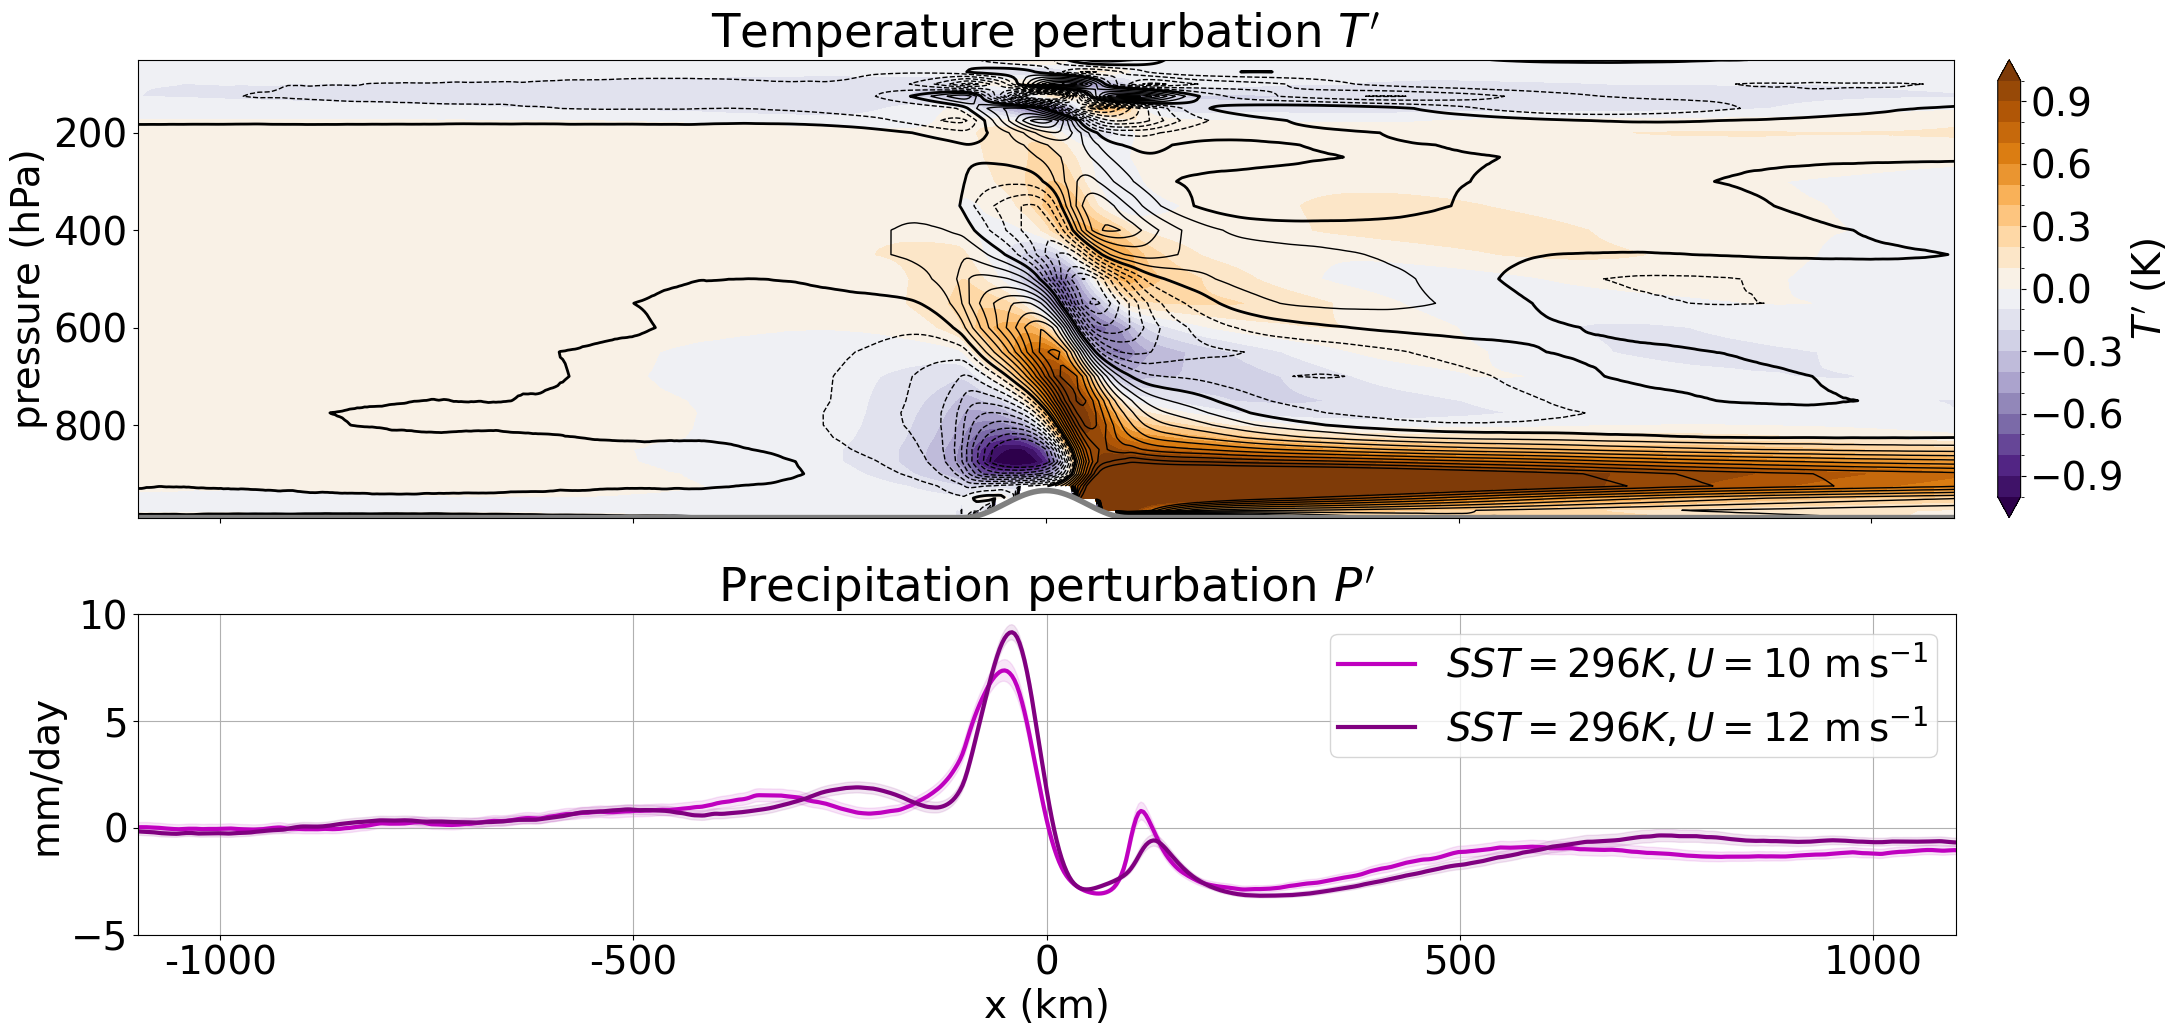

In [24]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(24,11),height_ratios=(1,0.7))


# Shadings & contours
levs = np.linspace(-1,1,21)
n=len(levs)

prime(W10S296.T_PL_MEAN).plot.contourf(ax=ax,y='pressure',yincrease=False,levels=levs,cmap=plt.cm.PuOr_r,extend='both',cbar_kwargs={'label':r"$T'$ (K)","pad":0.02})
prime(W12S296.T_PL_MEAN).plot.contour (ax=ax,y='pressure',yincrease=False,levels=levs,colors='k',linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))
#zeta_10.plot.contourf(ax=ax,y='z',levels=levs,cmap = plt.cm.PuOr_r,cbar_kwargs={'label':r"$\eta$ (m)","pad":0.02})
#(zeta_11).plot.contour(ax=ax,y='z',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# fill white space
ax.fill_between(xx/1e3,990*xx**0,990 - hx/9,color='w',zorder=2)
ax.plot(xx/1e3,990 - hx/9,color='gray',linewidth=4)

ax.set_xlim(-1100,1100)
ticks = np.arange(-1000,1100,500)
ax.set_xticks(list(ticks))
ax.set_xticklabels('')
ax.set_xlabel('')

ax.set_ylabel('pressure (hPa)')




for Sim in (W10S296,W12S296):
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color,label=Sim.label,linewidth=3)
    ax2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)

ax2.set_ylim(-5,10)
ax2.set_ylabel("mm/day")
ax2.set_xlim(-1100,1100)
ax2.set_xticks(list(ticks))
ax2.set_xticklabels(ticks)
ax2.set_xlabel('x (km)')

#yticks=np.arange(-40,41,20)
#ax2.set_yticks(yticks)
ax2.legend(loc=1,borderpad=0.2,fontsize=28)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=2.7, pad=1.,axes_class=plt.Axes)
cax2.remove()
ax2.grid()

ax.set_title(r"Temperature perturbation $T'$")
ax2.set_title(r"Precipitation perturbation $P'$")

fig.tight_layout()
#rect1 = matplotlib.patches.Rectangle((0,0), 200000, 1000, color='white',zorder=5)

#ax.add_patch(rect1)

(-1100.0, 1100.0)

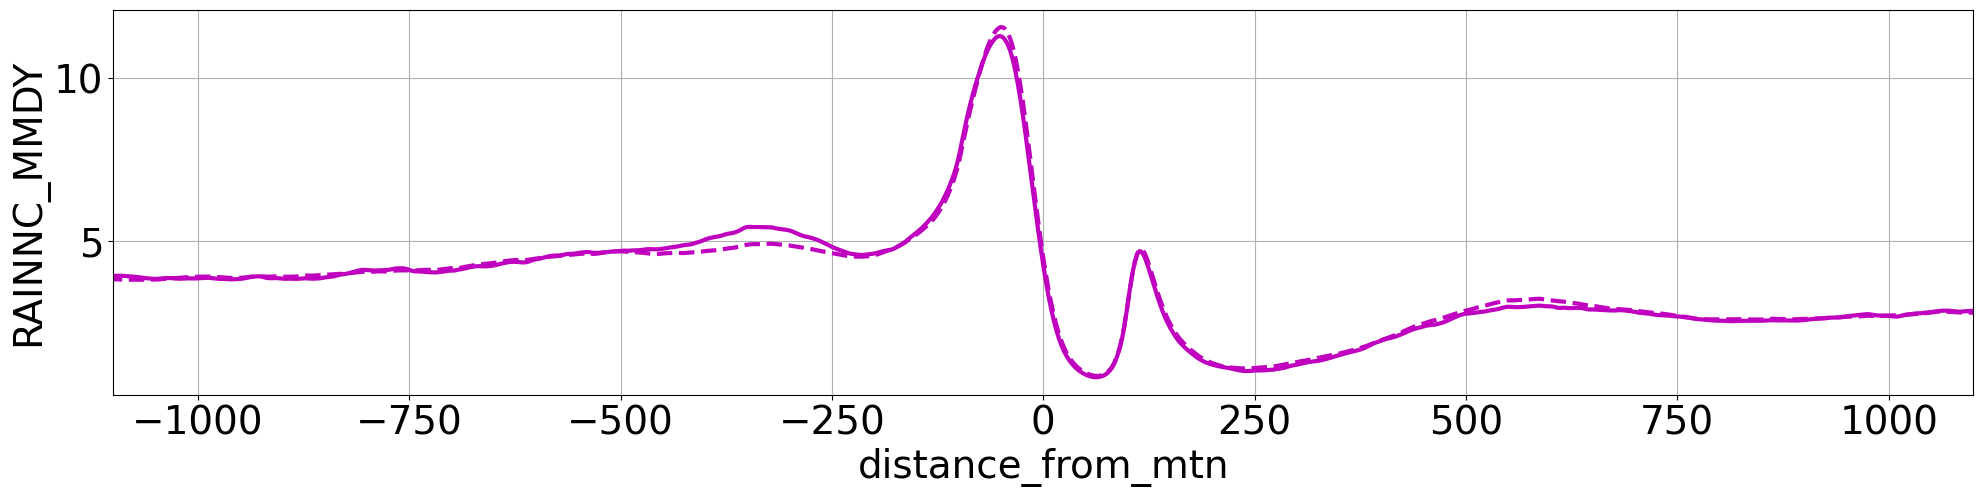

In [17]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax=plt.subplots(1,1,figsize=(24,5))

Sim = W10S296
Sim.RAINNC_MEAN.plot(ax=ax,color=Sim.color,label=Sim.label,linewidth=3)
Sim.RAINNC_DAILY_FULL.mean('Time').plot(ax=ax,color=Sim.color,linestyle='--',label=Sim.label,linewidth=3)
ax.grid()
ax.set_xlim(-1100,1100)

In [30]:
def ratio_CI(pr1,pr2,unit,norm=1):
    pr1=pr1.data; pr2=pr2.data
    nt1=len(pr1);nt2=len(pr2)
    sigma1=np.std(pr1);sigma2=np.std(pr2)
    
    meanratio = pr2.mean()/pr1.mean()
    deltaratio = meanratio * np.sqrt( (2*sigma1/np.sqrt(nt1)/pr1.mean())**2 + (2*sigma2/np.sqrt(nt2)/pr2.mean())**2)
    
    print("Change is %.1f %%/%s (95%% CI = [%.1f to %.1f])"%(100*(meanratio-1)/norm,unit,100*(meanratio-1-deltaratio)/norm,100*(meanratio-1+deltaratio)/norm))
    
    
ratio_CI(W10S296.RAINNC_DAILY.isel(distance_from_mtn=W10S296.RAINNC_MEAN.argmax())- upstream_mean(W10S296.RAINNC_MEAN),W12S296.RAINNC_DAILY.isel(distance_from_mtn=W12S296.RAINNC_MEAN.argmax())- upstream_mean(W12S296.RAINNC_MEAN),"m/s",2)
ratio_CI(W10S296.RAINNC_DAILY_FULL.isel(distance_from_mtn=W10S296.RAINNC_MEAN.argmax())- upstream_mean(W10S296.RAINNC_DAILY_FULL.mean('Time')),W12S296.RAINNC_DAILY.isel(distance_from_mtn=W12S296.RAINNC_MEAN.argmax())- upstream_mean(W12S296.RAINNC_MEAN),"m/s",2)



Change is 12.1 %/m/s (95% CI = [7.2 to 17.0])
Change is 9.9 %/m/s (95% CI = [6.5 to 13.3])


In [41]:
ratio_CI(W10S296.RAINNC_DAILY_FULL.isel(distance_from_mtn=W10S296.RAINNC_MEAN.argmax())[:930]- upstream_mean(W10S296.RAINNC_DAILY_FULL.mean('Time')),W12S296.RAINNC_DAILY.isel(distance_from_mtn=W12S296.RAINNC_MEAN.argmax())- upstream_mean(W12S296.RAINNC_MEAN),"m/s",2)

Change is 10.1 %/m/s (95% CI = [6.4 to 13.7])


In [33]:
from scipy.ndimage import gaussian_filter

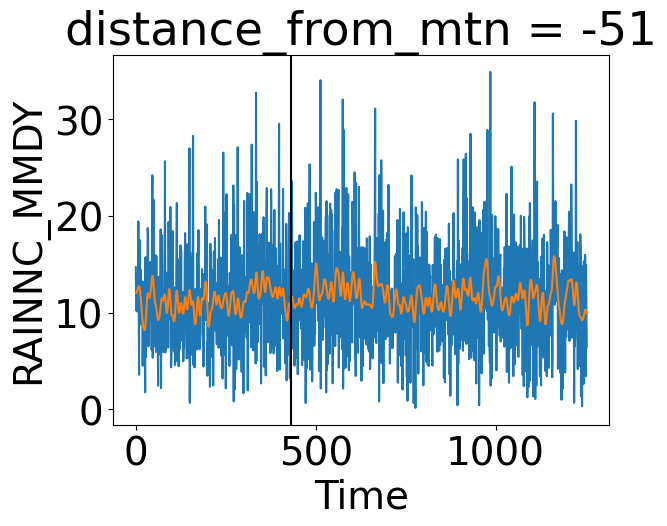

In [40]:
ts = W10S296.RAINNC_DAILY_FULL.isel(distance_from_mtn=W10S296.RAINNC_MEAN.argmax())
ts.plot()
(gaussian_filter(ts,3)*ts**0).plot()
plt.axvline(430,color='k')

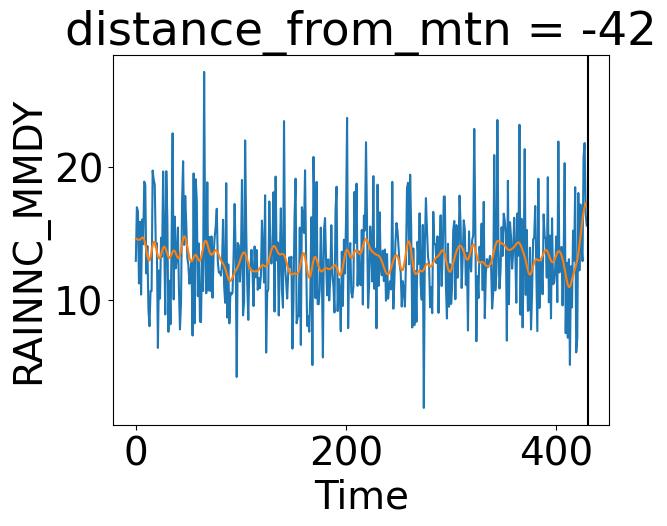

In [42]:
ts = W12S296.RAINNC_DAILY.isel(distance_from_mtn=W12S296.RAINNC_MEAN.argmax())
ts.plot()
(gaussian_filter(ts,3)*ts**0).plot()
plt.axvline(430,color='k')

In [22]:
(prime(W12S296.RAINNC_MEAN).max() / prime(W10S296.RAINNC_MEAN).max() - 1).data*100/2

12.122065800620375

In [25]:
idx10 = prime(W10S296.RAINNC_MEAN).argmax().data
idx12 = prime(W12S296.RAINNC_MEAN).argmax().data
ts1 = (W10S296.RAINNC_DAILY.isel(distance_from_mtn = idx10) - upstream_mean(W10S296.RAINNC_MEAN)).load().data
ts2 = (W12S296.RAINNC_DAILY.isel(distance_from_mtn = idx12) - upstream_mean(W12S296.RAINNC_MEAN)).load().data

In [27]:
blocksize=20
bootstrap_estimates = generate_sample(ts2,blocksize,nbootstrap=50000).mean(axis=1)/generate_sample(ts1,blocksize,nbootstrap=50000).mean(axis=1)
(np.quantile(bootstrap_estimates,[0.025,0.975])-1)/2*100

array([ 7.8993845 , 15.50391421])

In [28]:
blocksize=120
bootstrap_estimates2 = generate_sample(ts2,blocksize,nbootstrap=50000).mean(axis=1)/generate_sample(ts1,blocksize,nbootstrap=50000).mean(axis=1)
(np.quantile(bootstrap_estimates2,[0.025,0.975])-1)/2*100

array([ 6.42022237, 16.23360112])

In [19]:
# Considering only the first 430 days of the 10 m/s, 296K sim: 12.1 [ 6.46145985, 16.26582921]

# Simulations - B_L stuff

In [23]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines

from scipy.ndimage import gaussian_filter
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})


class SymHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle,xdescent, ydescent, width, height, fontsize, trans):
        xx= 0.6*height
        return super(SymHandler, self).create_artists(legend, orig_handle,xdescent, xx, width, height, fontsize, trans)

In [24]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
from orographicPrecipitation.observationsAndERA5.linearWaveModels import z_to_p_standard

def nonlinear_mountain_wave(x,h,z,U,N):
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z[None,:]-h[:,None]))+f[:,None]*np.sin(l*(z[None,:]-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    # displacement: xr.DataArray(z[None,:]-delta,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return xr.DataArray(w,coords={'distance_from_mtn':x/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])

z=np.linspace(0,20e3,200)
xx ,hx = topographic_profile('cos',A=500)
xx = xx[1000:3001]
hx = hx[1000:3001]

w_nonlinear_10=nonlinear_mountain_wave(xx,hx,z,10.,1e-2)
w_nonlinear_12=nonlinear_mountain_wave(xx,hx,z,12.,1e-2)
p = z_to_p_standard(w_nonlinear_10.altitude*1000)
w_nonlinear_10 = w_nonlinear_10.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})
w_nonlinear_12 = w_nonlinear_12.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})

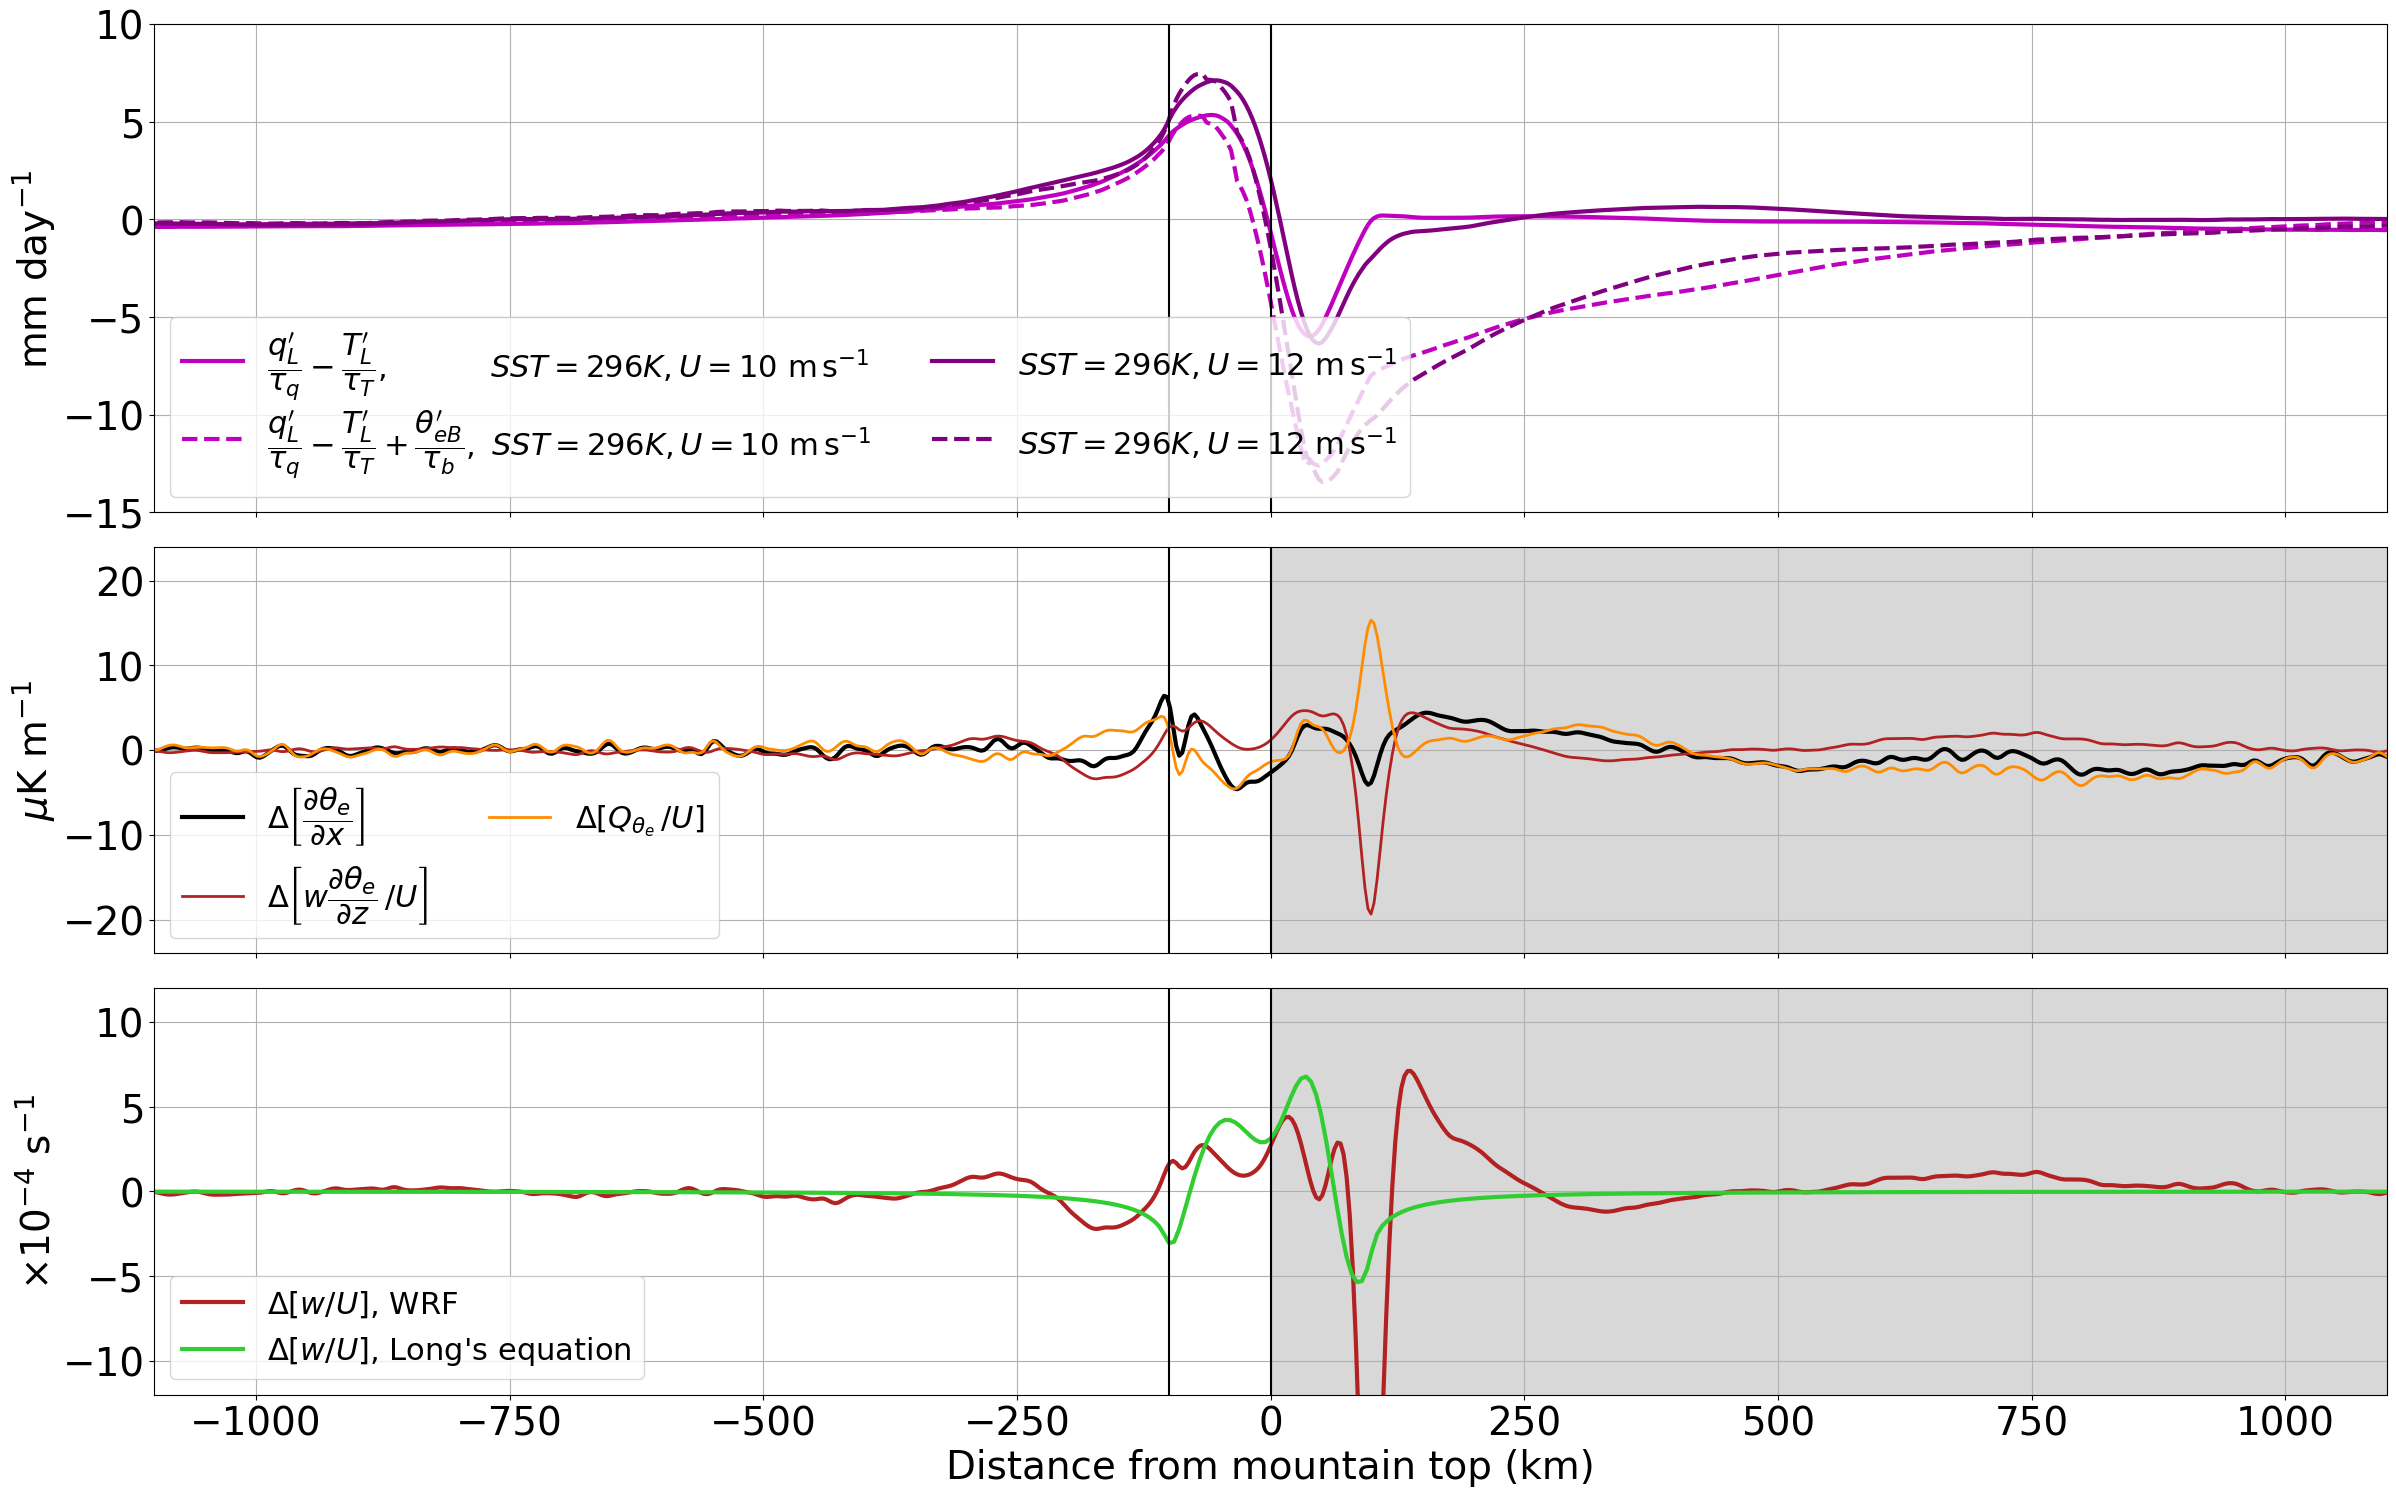

In [25]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs=plt.subplots(3,1,figsize=(24,15),height_ratios = [1.2,1.,1.])

legend_ftz=22
############################
######## FIRST PLOT ########
############################
ax = axs[0]
for i,Sim in enumerate((W10S296, W12S296)):
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    conversion = 1004./2.5e6 * 8000 * 86400
    if i==0:
        lbl1 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T},$          " + Sim.label
        lbl2 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}+\dfrac{\theta_{eB}'}{\tau_b},$ " + Sim.label
    else:
        lbl1 = Sim.label
        lbl2 = Sim.label
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5               )   / 3600).plot(ax=ax,linestyle='-' ,color = Sim.color,linewidth=3, label=lbl1)#Sim.color3
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5) / 3600).plot(ax=ax,linestyle='--',color = Sim.color,linewidth=3, label=lbl2)#Sim.color2
    

ax.set_ylim(-15,10)
ax.set_yticks(range(-15,11,5));
ax.legend(handler_map={matplotlib.lines.Line2D: SymHandler()}, 
          fontsize=legend_ftz, ncol=2,handleheight=3.5, labelspacing=0.05,loc=3,borderpad=0.4)

ax.set_ylabel(r'mm day$^{-1}$')

############################
####### SECOND PLOT ########
############################
ax=axs[1]
Delta0 = 1e6*(W12S296.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3 
         -W10S296.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3
         )
smooth(Delta0).plot(ax=ax,label = r"$\Delta \left[\dfrac{\partial \theta_e}{\partial x}\right]$",color='k',linewidth=3)

Delta1 = 1e6*((- W12S296.OMEGADTHETAEDP/86400)/12-(- W10S296.OMEGADTHETAEDP/86400)/10).sel(pressure=925)
smooth(Delta1).plot(ax=ax,color='firebrick',linewidth=2,label = r"$\Delta \left[w\dfrac{\partial \theta_e}{\partial z} \,/ U\right]$")

Delta2 = 1e6*((W12S296.QTHETAE/86400)/12-(W10S296.QTHETAE/86400)/10).sel(pressure=925)
smooth(Delta2).plot(ax=ax,color='darkorange',linewidth=2,label = r"$\Delta[ Q_{\theta_e} \,/ U]$ ")

ax.legend(fontsize=legend_ftz,loc=3,ncol=2)
ax.set_ylabel(r"$\mu$K m$^{-1}$")
ax.set_ylim(-24,24)
ax.fill_between([0,1100],[-24,-24],[24,24.],color='gray',alpha=0.3)


############################
######## THIRD PLOT ########
############################
ax=axs[2]

smooth((1e4*(W12S296.W_PL_MEAN/12 - W10S296.W_PL_MEAN/10)).sel(pressure=925))    .plot(ax=ax,color='firebrick',linewidth=3,label=r"$\Delta[w/U]$, WRF")
(1e4*(w_nonlinear_12/12 - w_nonlinear_10/10)).sel(pressure=925.,method='nearest').plot(ax=ax,color='limegreen',linewidth=3,label=r"$\Delta[w/U]$, Long's equation")

ax.legend(fontsize=legend_ftz,loc=3)
ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)

ax.set_ylim(-12,12)
ax.set_ylabel(r"$\times 10^{-4}$ s$^{-1}$")

############################
###### FINAL TOUCHES #######
############################
for ax in axs:
    ax.set_title('')
    ax.set_xlim(-1100,1100)
    ax.grid()
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
for ax in axs[:2]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
axs[2].set_xlabel('Distance from mountain top (km)')
fig.tight_layout(pad=0.3)

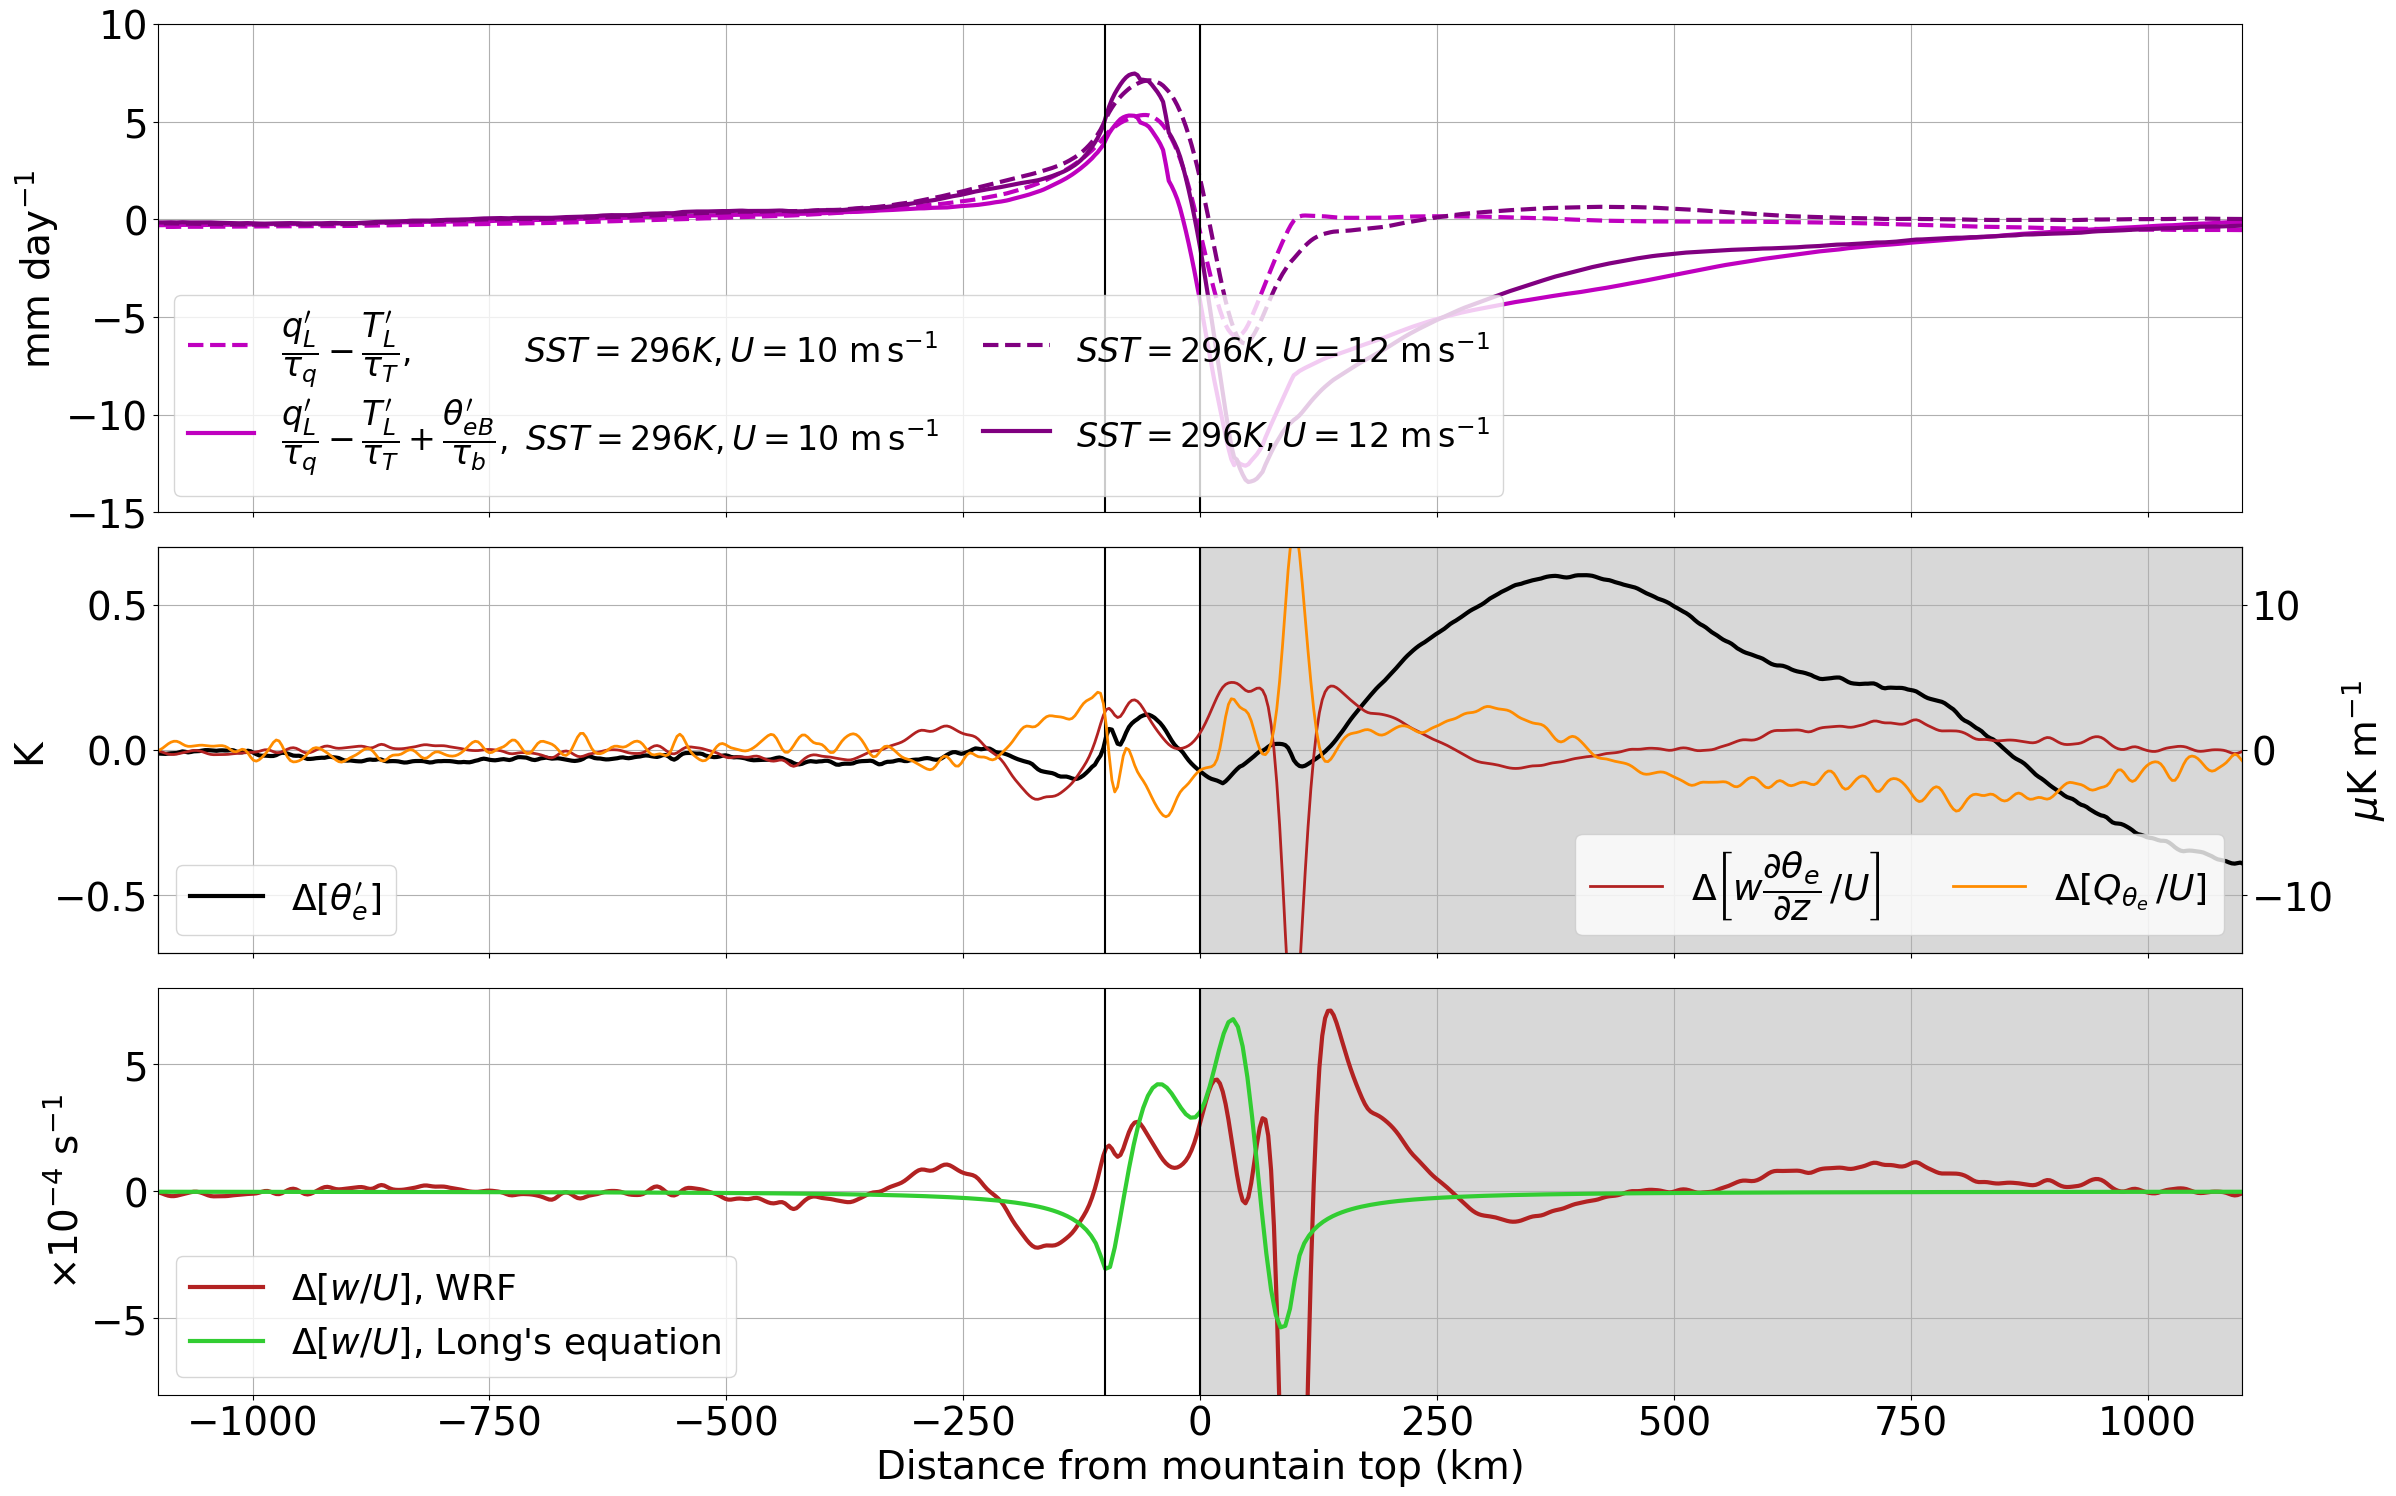

In [26]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs=plt.subplots(3,1,figsize=(24,15),height_ratios = [1.2,1.,1.])

legend_ftz=24
############################
######## FIRST PLOT ########
############################
ax = axs[0]
for i,Sim in enumerate((W10S296, W12S296)):
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    conversion = 1004./2.5e6 * 8000 * 86400
    if i==0:
        lbl1 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T},$          " + Sim.label
        lbl2 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}+\dfrac{\theta_{eB}'}{\tau_b},$ " + Sim.label
    else:
        lbl1 = Sim.label
        lbl2 = Sim.label
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5               )   / 3600).plot(ax=ax,linestyle='--' ,color = Sim.color,linewidth=3, label=lbl1)#Sim.color3
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5) / 3600).plot(ax=ax,linestyle='-',color = Sim.color,linewidth=3, label=lbl2)#Sim.color2
    

ax.set_ylim(-15,10)
ax.set_yticks(range(-15,11,5));
ax.legend(handler_map={matplotlib.lines.Line2D: SymHandler()}, 
          fontsize=legend_ftz, ncol=2,handleheight=3.5, labelspacing=0.05,loc=3,borderpad=0.4,columnspacing=1.3)

ax.set_ylabel(r'mm day$^{-1}$')

############################
####### SECOND PLOT ########
############################
ax=axs[1]
ax2 = ax.twinx()
(prime(W12S296.THETAE_MEAN.sel(pressure=925))-prime(W10S296.THETAE_MEAN.sel(pressure=925))).plot(ax=ax,label = r"$\Delta[ \theta_e']$",color='k',linewidth=3)

Delta1 = 1e6*((- W12S296.OMEGADTHETAEDP/86400)/12-(- W10S296.OMEGADTHETAEDP/86400)/10).sel(pressure=925)
smooth(Delta1).plot(ax=ax2,color='firebrick',linewidth=2,label = r"$\Delta \left[w\dfrac{\partial \theta_e}{\partial z} \,/ U\right]$")

Delta2 = 1e6*((W12S296.QTHETAE/86400)/12-(W10S296.QTHETAE/86400)/10).sel(pressure=925)
smooth(Delta2).plot(ax=ax2,color='darkorange',linewidth=2,label = r"$\Delta[ Q_{\theta_e} \,/ U]$ ")

ax.legend(fontsize=legend_ftz+2,loc=3,ncol=2)
ax.set_ylabel(r"K")
ax.set_ylim(-0.7,0.7)
ax.fill_between([0,1100],[-24,-24],[24,24.],color='gray',alpha=0.3)


ax2.legend(fontsize=legend_ftz+2,loc=4,ncol=2)
ax2.set_ylabel(r"$\mu$K m$^{-1}$")
ax2.set_ylim(-14,14)
ax2.set_title('')

############################
######## THIRD PLOT ########
############################
ax=axs[2]

smooth((1e4*(W12S296.W_PL_MEAN/12 - W10S296.W_PL_MEAN/10)).sel(pressure=925))    .plot(ax=ax,color='firebrick',linewidth=3,label=r"$\Delta[w/U]$, WRF")
(1e4*(w_nonlinear_12/12 - w_nonlinear_10/10)).sel(pressure=925.,method='nearest').plot(ax=ax,color='limegreen',linewidth=3,label=r"$\Delta[w/U]$, Long's equation")

ax.legend(fontsize=legend_ftz+2,loc=3)
ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)

ax.set_ylim(-8,8)
ax.set_ylabel(r"$\times 10^{-4}$ s$^{-1}$")

############################
###### FINAL TOUCHES #######
############################
for ax in axs:
    ax.set_title('')
    ax.set_xlim(-1100,1100)
    ax.grid()
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
for ax in axs[:2]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
axs[2].set_xlabel('Distance from mountain top (km)')
fig.tight_layout(pad=0.3)

In [27]:
measures = [[],[],[]]
for Sim in W10S296 , W12S296:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    measures[0].append(prime(Sim.RAINNC_MEAN))
    measures[1].append(- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5)
    measures[2].append(- prime(TL) / 7.5 + prime(qL)/27.5 )

for i in range(len(measures)):
    change = (measures[i][1].max()/measures[i][0].max() - 1) *100/2
    print( "%.2f %%/(m/s)"%(change) )
    

9.88 %/(m/s)
20.21 %/(m/s)
16.61 %/(m/s)
